## Correctness of the Fourier Transform
An important part of the algorithm used on the Match filter is the calculation of the Fourier Transform, here we abord the problem using signal decomposition, were we have input data vector $y$ expresed as:

$$ y = \Phi \beta $$

Where $\Phi$ is the dictionary and $\beta$ are the coeficients of the decomposition. In the sense of fourier, the dictionary will be a fourier matrix where every column will be a sinusoidal signal constructed on the time samples of the input data with a period given by a frequency grid, this means, $\Phi$ is a matrix of $m \times n$ where $m$ is the number of frequency to use in the decomposition and $n$ is the number of time samples of the input data. This matrix in the case of Non-uniform sampling probably will not be an invertible matrix and then the values of $\beta$ cannot be calculated analiticaly. Instead, we can use an iterative method to solve this problem. We choose to use Stochastic Gradient Descendent method:

$$ $$

with a least-square loss function with L2 norm.

In order to check the correct behavior of all the discretization and aproximated solutions made by the code, we are going to verify in different steps the computations results and their validity.

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import time
import sys

from collections import defaultdict

sys.path.append("../..")
from mfilter.regressions import *
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.filter import *
from microlensing.lib.microlensing import *
from matplotlib.mlab import psd

%matplotlib inline
plt.style.use('seaborn')
fsize = 16

In [33]:
help(psd)

Help on function psd in module matplotlib.mlab:

psd(x, NFFT=None, Fs=None, detrend=None, window=None, noverlap=None, pad_to=None, sides=None, scale_by_freq=None)
    Compute the power spectral density.
    
    Call signature::
    
        psd(x, NFFT=256, Fs=2, detrend=mlab.detrend_none,
            window=mlab.window_hanning, noverlap=0, pad_to=None,
            sides='default', scale_by_freq=None)
    
    The power spectral density :math:`P_{xx}` by Welch's average
    periodogram method.  The vector *x* is divided into *NFFT* length
    segments.  Each segment is detrended by function *detrend* and
    windowed by function *window*.  *noverlap* gives the length of
    the overlap between segments.  The :math:`|\mathrm{fft}(i)|^2`
    of each segment :math:`i` are averaged to compute :math:`P_{xx}`.
    
    If len(*x*) < *NFFT*, it will be zero padded to *NFFT*.
    
    Parameters
    ----------
    x : 1-D array or sequence
        Array or sequence containing the data
    
  

0.125
2.5
80.0


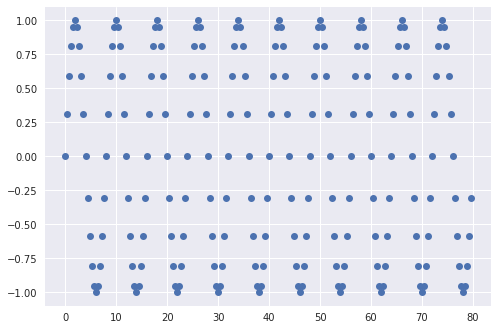

In [21]:
# generate a basic data for testing
delta_t = 0.4
n = 200
struct = "regular" # can be changed
freq = 10/(n*delta_t)
print(freq)
print(1/delta_t)
print(n * delta_t)

def get_data(n, delta_t, freq, struct):
    times = TimesSamples(initial_array=None, n=n, delta=delta_t, struct=struct)
    temp = TimeSeries(np.sin(2 * np.pi * freq * times), times=times)
    return times, temp
times, temp = get_data(n, delta_t, freq, struct)
plt.plot(times, temp, 'o')

### Questions about Fourier Transform
Here we observe that changing the number of frequencies can affect higly the convergence of the iterative method, from this we can ask a few questions (Convergence here means an $R^2$ factor close to 1)
* 1. Could the nyquist frequency be a factor?
    + for this we compute a regular sampling for which is easly to find the nyquist limit, then we change the range of the frequencies and check if this affect the convergence.

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 5.48 µs


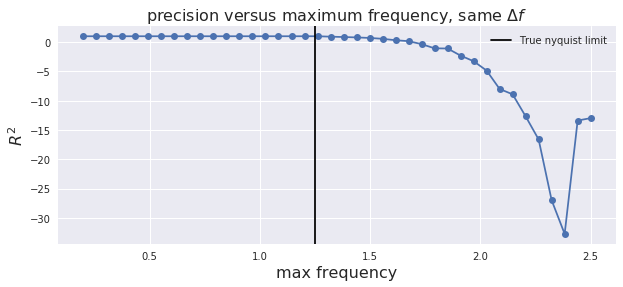

In [17]:
# 1:
%time
def q1(times, data, sin_freq):
    nyq = 1 / (2 * delta_t)
    range_max_freq = np.linspace(2 * sin_freq, nyq + nyq, 40)
    samples_per_peak = 5 # fixed
    df = 1 / times.duration / samples_per_peak # fixed
    stildes = []
    scores = []
    for max_freq in range_max_freq:
        freqs = FrequencySamples(input_time=times,
                                 minimum_frequency=df,
                                 maximum_frequency=max_freq,
                                 samples_per_peak=samples_per_peak)
        F = Dictionary(times, freqs)
        reg = SGDRegression(alpha=10**(-4), tol=0.001, max_iter=500, phi=F) # fixed alpha and max_iter
        reg.coef_ = np.zeros(F.shape(splited=True)[1]) # reset the coef to avoid bias
        stildes.append(data.to_frequencyseries(reg=reg))
        scores.append(reg.score(data))
        
    plt.figure(figsize=(10, 4))
    plt.plot(range_max_freq, scores, 'o-')
    plt.axvline(nyq, color='k', label="True nyquist limit")
    plt.ylabel(r"$R^2$", fontsize=fsize)
    plt.xlabel("max frequency", fontsize=fsize)
    plt.title("precision versus maximum frequency, same $\Delta f$", fontsize=fsize)
    plt.legend()
# plt.figure(figsize=(10, 4))
# plt.plot(freqs, abs(stilde))
# plt.axvline(freq, color="k")
q1(times, temp, freq)

* 2. the sampling rate on frequencies could affect the convergence?
    + For this we just plot a small range with a dense sampling agains a big range with a not dense sampling.

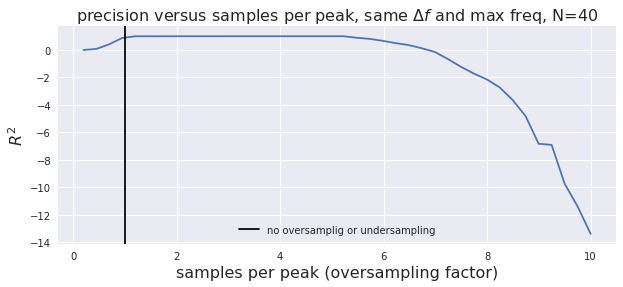

In [26]:
def q2(times, data, sin_freq):
    N = 40
    nyq = 1 / (2 * delta_t) # max frequnecy fixed
    range_samples_per_peak = np.linspace(0.2, 10, N)
    df = 1 / times.duration # basic df fixed, change samples per peak
    stildes = []
    scores = []
    for samples_per_peak in range_samples_per_peak:
        freqs = FrequencySamples(input_time=times,
                                 minimum_frequency=df / samples_per_peak,
                                 maximum_frequency=nyq,
                                 samples_per_peak=samples_per_peak)
        F = Dictionary(times, freqs)
        reg = SGDRegression(alpha=10**(-4), tol=0.001, max_iter=500, phi=F) # fixed alpha and max_iter
        reg.coef_ = np.zeros(F.shape(splited=True)[1]) # reset the coef to avoid bias
        stildes.append(data.to_frequencyseries(reg=reg))
        scores.append(reg.score(data))
        
    plt.figure(figsize=(10, 4))
    plt.plot(range_samples_per_peak, scores)
    plt.axvline(1, color='k', label="no oversamplig or undersampling")
    plt.ylabel(r"$R^2$", fontsize=fsize)
    plt.xlabel("samples per peak (oversampling factor)", fontsize=fsize)
    plt.title("precision versus samples per peak, same $\Delta f$ and max freq, N={}".format(N), fontsize=fsize)
    plt.legend()
    
q2(times, temp, freq)

* 3. the sampling rate on times affect the convergence?
    + in theory if we have an average sampling rate that satisfied the Nyquist-shannon theorem then it can be transformed correctly, so we are going to check different sampling rates on regular and irregular sampling and check how bad goes the convergence of the Transform when the number of frequencies change

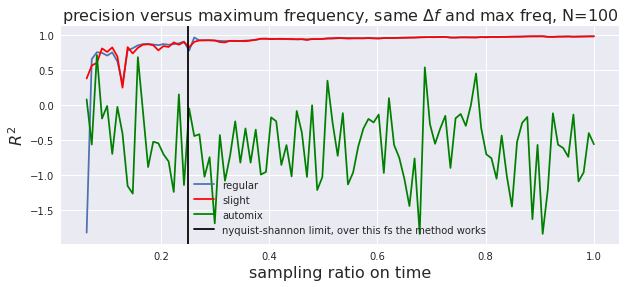

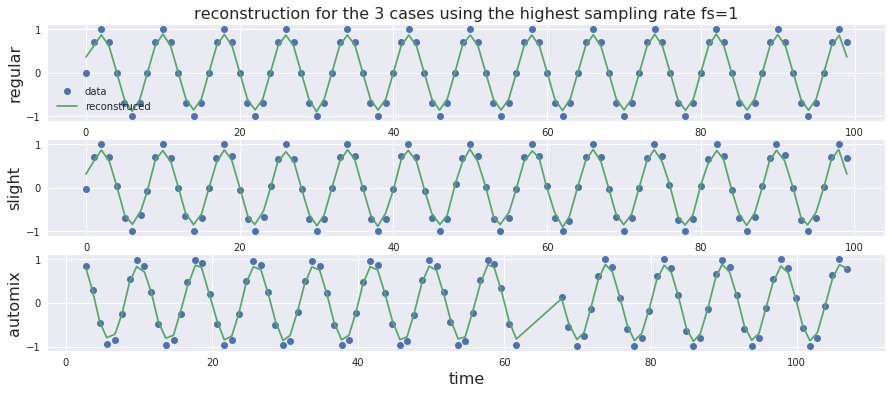

In [55]:
def q3(sin_freq, time_duration):
    N=100
    range_fs = np.linspace(sin_freq/2, 1, N)
    stildes = []
    stildes2 = []
    stildes3 = []
    scores = []
    scores2 = []
    scores3 = []
    for fs in range_fs:
        n = int(round(time_duration * fs))
        times, data = get_data(delta_t=1/fs, freq=sin_freq, n=n, struct="regular")
        times2, data2 = get_data(delta_t=1/fs, freq=sin_freq, n=n, struct="slight")
        times3, data3 = get_data(delta_t=1/fs, freq=sin_freq, n=n, struct="automix")
        nyq = fs/2
        df = 1/times.duration
        df2 = 1/times2.duration
        df3 = 1/times3.duration
        freqs = FrequencySamples(input_time=times,
                                 minimum_frequency=df,
                                 maximum_frequency=nyq,
                                 samples_per_peak=1) # no oversampling factor
        freqs2 = FrequencySamples(input_time=times2,
                                 minimum_frequency=df2,
                                 maximum_frequency=nyq,
                                 samples_per_peak=1) # no oversampling factor
        freqs3 = FrequencySamples(input_time=times3,
                                 minimum_frequency=df3,
                                 maximum_frequency=nyq,
                                 samples_per_peak=1) # no oversampling factor
        F = Dictionary(times, freqs)
        F2 = Dictionary(times2, freqs2)
        F3 = Dictionary(times3, freqs3)
        reg = SGDRegression(alpha=10**(-4), tol=0.001, max_iter=500, phi=F) # fixed alpha and max_iter
        reg2 = SGDRegression(alpha=10**(-4), tol=0.001, max_iter=500, phi=F2) # fixed alpha and max_iter
        reg3 = SGDRegression(alpha=10**(-4), tol=0.001, max_iter=500, phi=F3) # fixed alpha and max_iter
        reg.coef_ = np.zeros(F.shape(splited=True)[1]) # reset the coef to avoid bias
        reg2.coef_ = np.zeros(F2.shape(splited=True)[1])
        reg3.coef_ = np.zeros(F3.shape(splited=True)[1])
        
        stildes.append(data.to_frequencyseries(reg=reg))
        scores.append(reg.score(data))
        stildes2.append(data2.to_frequencyseries(reg=reg2))
        scores2.append(reg2.score(data2))
        stildes3.append(data3.to_frequencyseries(reg=reg3))
        scores3.append(reg2.score(data3))
        
    plt.figure(figsize=(10, 4))
    plt.plot(range_fs, scores, label="regular")
    plt.plot(range_fs, scores2, 'r', label="slight")
    plt.plot(range_fs, scores3, 'g', label="automix")
    plt.axvline(2*sin_freq, color='k', label="nyquist-shannon limit, over this fs the method works")
    plt.ylabel(r"$R^2$", fontsize=fsize)
    plt.xlabel("sampling ratio on time", fontsize=fsize)
    plt.title("precision versus maximum frequency, same $\Delta f$ and max freq, N={}".format(N), fontsize=fsize)
    plt.legend()
    
    fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(15, 6))
    ax1.plot(times, data, 'o', label="data")
    ax1.plot(times, reg.predict(phi=F), label="reconstruced")
    ax1.legend()
    ax2.plot(times2, data2, 'o')
    ax2.plot(times2, reg2.predict(phi=F2))
    ax3.plot(times3, data3, 'o')
    ax3.plot(times3, reg3.predict(phi=F3))
    ax1.set_title("reconstruction for the 3 cases using the highest sampling rate fs=1", fontsize=fsize)
    ax1.set_ylabel("regular", fontsize=fsize)
    ax2.set_ylabel("slight", fontsize=fsize)
    ax3.set_ylabel("automix", fontsize=fsize)
    ax3.set_xlabel("time", fontsize=fsize)
    
q3(freq, 100)

* 4. relevant frequencies to smalls and too close can affect the convergence?
    + here we just check the convergence for different simple sinusoidal signals generated with different frequencies.

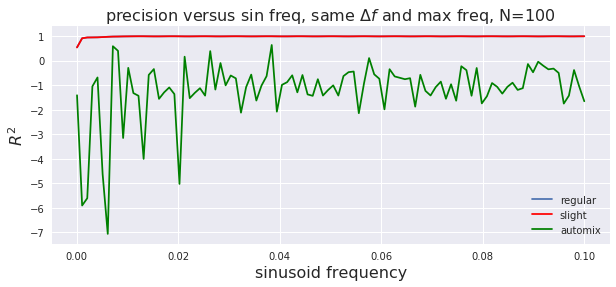

In [65]:
def q4(dt, n):
    N = 100
    range_freq = np.linspace(0.0001, 0.1, N)
    nyq = 1/(2*dt)
    stildes = []
    stildes2 = []
    stildes3 = []
    scores = []
    scores2 = []
    scores3 = []
    for freq in range_freq:
        times, data = get_data(delta_t=dt, freq=freq, n=n, struct="regular")
        times2, data2 = get_data(delta_t=dt, freq=freq, n=n, struct="slight")
        times3, data3 = get_data(delta_t=dt, freq=freq, n=n, struct="automix")
        df = 1/times.duration
        df2 = 1/times2.duration
        df3 = 1/times3.duration
        freqs = FrequencySamples(input_time=times,
                                 minimum_frequency=df,
                                 maximum_frequency=nyq,
                                 samples_per_peak=1) # no oversampling factor
        freqs2 = FrequencySamples(input_time=times2,
                                 minimum_frequency=df2,
                                 maximum_frequency=nyq,
                                 samples_per_peak=1) # no oversampling factor
        freqs3 = FrequencySamples(input_time=times3,
                                 minimum_frequency=df3,
                                 maximum_frequency=nyq,
                                 samples_per_peak=1) # no oversampling factor
        F = Dictionary(times, freqs)
        F2 = Dictionary(times2, freqs2)
        F3 = Dictionary(times3, freqs3)
        reg = SGDRegression(alpha=10**(-4), tol=0.001, max_iter=500, phi=F) # fixed alpha and max_iter
        reg2 = SGDRegression(alpha=10**(-4), tol=0.001, max_iter=500, phi=F2) # fixed alpha and max_iter
        reg3 = SGDRegression(alpha=10**(-4), tol=0.001, max_iter=500, phi=F3) # fixed alpha and max_iter
        reg.coef_ = np.zeros(F.shape(splited=True)[1]) # reset the coef to avoid bias
        reg2.coef_ = np.zeros(F2.shape(splited=True)[1])
        reg3.coef_ = np.zeros(F3.shape(splited=True)[1])
        
        stildes.append(data.to_frequencyseries(reg=reg))
        scores.append(reg.score(data))
        stildes2.append(data2.to_frequencyseries(reg=reg2))
        scores2.append(reg2.score(data2))
        stildes3.append(data3.to_frequencyseries(reg=reg3))
        scores3.append(reg2.score(data3))
    plt.figure(figsize=(10, 4))
    plt.plot(range_freq, scores, label="regular")
    plt.plot(range_freq, scores2, 'r', label="slight")
    plt.plot(range_freq, scores3, 'g', label="automix")
#     plt.axvline(2*sin_freq, color='k', label="nyquist-shannon limit, over this fs the method works")
    plt.ylabel(r"$R^2$", fontsize=fsize)
    plt.xlabel("sinusoid frequency", fontsize=fsize)
    plt.title("precision versus sin freq, same $\Delta f$ and max freq, N={}".format(N), fontsize=fsize)
    plt.legend()
    
q4(delta_t, n)

then, as long as we use frequency grid with a max frequency not much higher than the true nyquist limit and with an oversampling factor not too high (a limt could depend on the type of data), how the method converger will only depend  on the parameters like alpha tolerance and max number of iterations, this is different for different types of data being better when more regular is the data.

### Questions about scales of the transform
* since we know that the parseval's theorem doesn't hold for non uniform samples, we can't check if the energy is conserved but we can check a ratio

$$ r = \frac{\sum |x_i|^2 \Delta t_i}{\sum |k_j|^2 \Delta f_j}  $$

and with this we ask:

* 1. does the ratio change when the duration of the observation change?
    + simply take same time sampling but add more or less samples

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


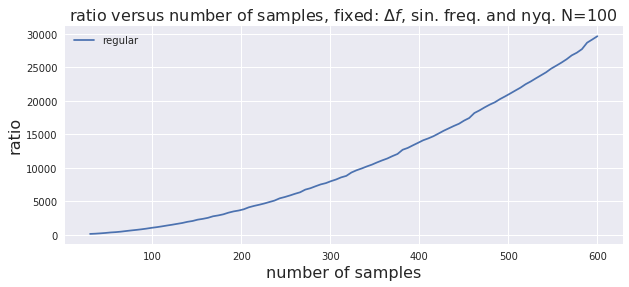

In [34]:
import pdb
def ratio(timeSeries, freqSeries):
    timeDeltas = deltas(timeSeries.times)
    freqDeltas = deltas(freqSeries.frequencies)
    sumTimes = 0
    sumFreqs = 0
    for i in range(0, len(timeSeries)-1):
        sumTimes += np.abs(timeSeries[i])**2 * timeDeltas[i]
    for i in range(0, len(freqSeries)):
        sumFreqs += np.abs(freqSeries[i])**2 * freqDeltas[i]
    return sumTimes / sumFreqs
    

def deltas(timeArray):
    deltasArray = np.zeros(len(timeArray))
    deltasArray[0] = timeArray[1] - timeArray[0]
    deltasArray[len(timeArray)-1] = timeArray[len(timeArray)-1] - timeArray[len(timeArray)-2]
    for i in range(1, len(timeArray)-1):
        deltasArray[i] = (timeArray[i+1] - timeArray[i-1])/2
    return deltasArray
%time
def p2q1(dt, sin_freq):
    N = 100
    range_n = np.linspace(30, 600, N)
    # sampling rate is constant
    nyq = 1/(2 * dt) # fixed
    stildes = []
    ratios = []
    for n in range_n:
        print(n, end="\r")
        times, data = get_data(delta_t=dt, freq=sin_freq, n=n, struct="regular")
        df = 1/times.duration
        freqs = FrequencySamples(input_time=times,
                                 minimum_frequency=df,
                                 maximum_frequency=nyq,
                                 samples_per_peak=1) # no oversampling factor
        F = Dictionary(times, freqs)
        reg = SGDRegression(alpha=10**(-4), tol=0.001, max_iter=500, phi=F) # fixed alpha tol and max_iter
        reg.coef_ = np.zeros(F.shape(splited=True)[1]) # reset the coef to avoid bias
        stilde = data.to_frequencyseries(reg=reg)
        stildes.append(stilde)
        ratios.append(ratio(data, stilde))
        
    plt.figure(figsize=(10, 4))
    plt.plot(range_n, ratios, label="regular")
#     plt.plot(range_freq, scores2, 'r', label="slight")
#     plt.plot(range_freq, scores3, 'g', label="automix")
#     plt.axvline(2*sin_freq, color='k', label="nyquist-shannon limit, over this fs the method works")
    plt.ylabel("ratio", fontsize=fsize)
    plt.xlabel("number of samples", fontsize=fsize)
    plt.title("ratio versus number of samples, fixed: $\Delta f$, sin. freq. and nyq. N={}".format(N), fontsize=fsize)
    plt.legend()
    
p2q1(delta_t, freq)

* 2. is the ratio affected by the oversampling of frequencies?
    + this is related to the convergence of the method, we should expect that if we change the sampling grid on frequencies the ratio will remains constant, but as we seen before, too high oversampling rate cause a fail in the method

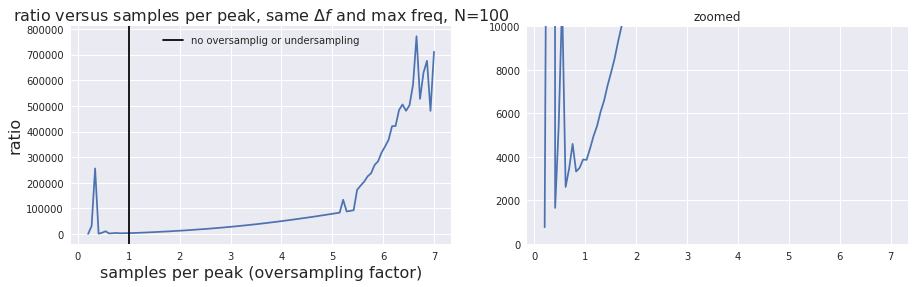

In [33]:
def p2q2(times, data, dt, sin_freq):
    N = 100
    nyq = 1 / (2 * dt) # max frequnecy fixed
    range_samples_per_peak = np.linspace(0.2, 7, N)
    df = 1 / times.duration # basic df fixed, change samples per peak
    stildes = []
    ratios = []
    for samples_per_peak in range_samples_per_peak:
        freqs = FrequencySamples(input_time=times,
                                 minimum_frequency=df / samples_per_peak,
                                 maximum_frequency=nyq,
                                 samples_per_peak=samples_per_peak)
        F = Dictionary(times, freqs)
        reg = SGDRegression(alpha=10**(-4), tol=0.001, max_iter=500, phi=F) # fixed alpha and max_iter
        reg.coef_ = np.zeros(F.shape(splited=True)[1]) # reset the coef to avoid bias
        stilde = data.to_frequencyseries(reg=reg)
        stildes.append(stilde)
        ratios.append(ratio(data, stilde))
        
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
    ax1.plot(range_samples_per_peak, ratios)
    ax1.axvline(1, color='k', label="no oversamplig or undersampling")
    ax2.plot(range_samples_per_peak, ratios)
    ax2.set_ylim([0, 10000])
    ax1.set_ylabel("ratio", fontsize=fsize)
    ax1.set_xlabel("samples per peak (oversampling factor)", fontsize=fsize)
    ax1.set_title("ratio versus samples per peak, same $\Delta f$ and max freq, N={}".format(N), fontsize=fsize)
    ax1.legend()
    ax2.set_title("zoomed")
    
p2q2(times, temp, delta_t, freq)

   
* 3. does the sampling of time affect the ratio?
    + the iterative method for the transform should compense the sampling grid but we need to check

### Questions about the change in transform because of change in frequency grid
* change the frequency grid by impossing an oversampling factor should change the values of the peaks in order to compense the change in the $\Delta f$

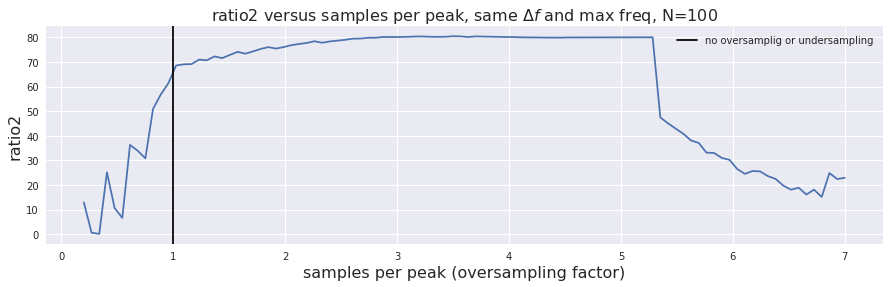

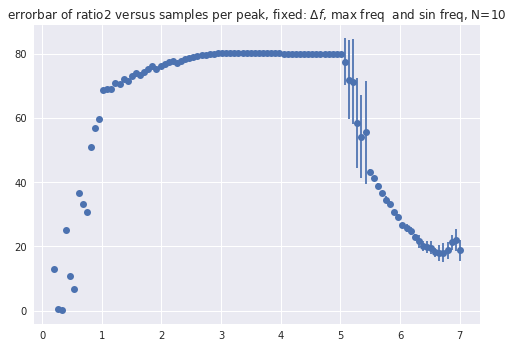

In [16]:
import pdb
def ratio2(freqSeries):
    suma = 0
    for i in range(len(freqSeries)):
        suma += np.abs(freqSeries[i])**2
    return suma / freqSeries.delta_f

def p3q(times, data, dt, sin_freq, plot=True):
    N = 100
    nyq = 1 / (2 * dt) # max frequnecy fixed
    range_samples_per_peak = np.linspace(0.2, 7, N)
    df = 1 / times.duration # basic df fixed, change samples per peak
    stildes = []
    ratios = []
    for samples_per_peak in range_samples_per_peak:
        print(samples_per_peak, end="\r")
        freqs = FrequencySamples(input_time=times,
                                 minimum_frequency=df / samples_per_peak,
                                 maximum_frequency=nyq,
                                 samples_per_peak=samples_per_peak)
        F = Dictionary(times, freqs)
        reg = SGDRegression(alpha=10**(-4), tol=0.001, max_iter=500, phi=F) # fixed alpha and max_iter
        reg.coef_ = np.zeros(F.shape(splited=True)[1]) # reset the coef to avoid bias
        stilde = data.to_frequencyseries(reg=reg)
        stildes.append(stilde)
        ratios.append(ratio2(stilde))
#     pdb.set_trace()
    if plot:
        fig = plt.figure(figsize=(15, 4))
        plt.plot(range_samples_per_peak, ratios)
        plt.axvline(1, color='k', label="no oversamplig or undersampling")
        plt.ylabel("ratio2", fontsize=fsize)
        plt.xlabel("samples per peak (oversampling factor)", fontsize=fsize)
        plt.title("ratio2 versus samples per peak, same $\Delta f$ and max freq, N={}".format(N), fontsize=fsize)
        plt.legend()
    return ratios, range_samples_per_peak

def mean_p3q(times, data, dt, sin_freq, N=10):
    ratiosDict = defaultdict(list)
    for i in range(N):
        ratios, range_var = p3q(times, data, dt, sin_freq, plot=False)
        for j in range(len(ratios)):
            ratiosDict[j].append(ratios[j])
    ratiosMean = []
    ratiosStd = []
    for k, v in ratiosDict.items():
        ratiosMean.append(np.mean(v))
        ratiosStd.append(np.std(v))
    plt.figure()
    plt.title("errorbar of ratio2 versus samples per peak, fixed: $\Delta f$, max freq  and sin freq, N={}".format(N))
    plt.errorbar(range_var, ratiosMean, yerr=ratiosStd, fmt='o')
    
p3q(times, temp, delta_t, freq)
mean_p3q(times, temp, delta_t, freq)

or we can think of a conservation of energy on the frequency domain, means, for different frequency grid the energy should remain the same, this is simple to check

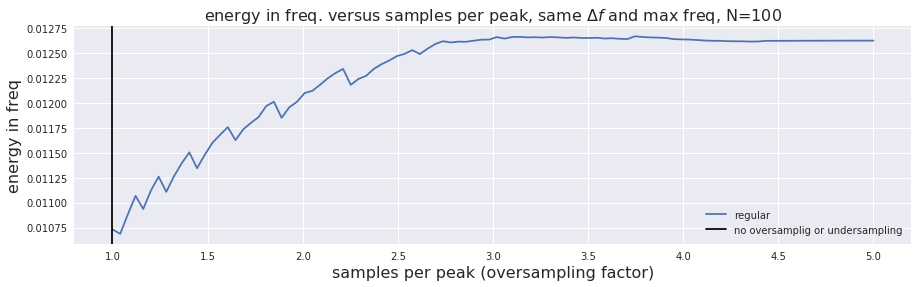

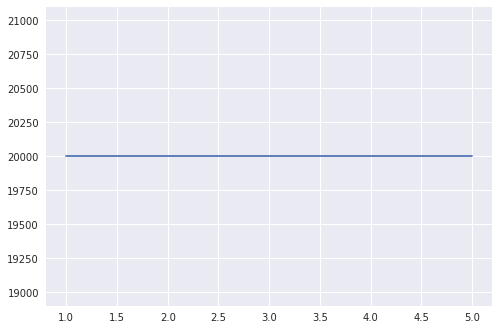

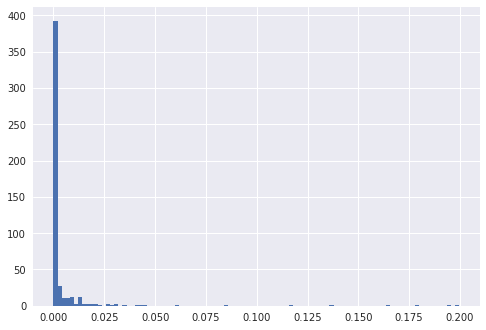

In [55]:
def energy(freqSeries):
    e = 0
    for i in range(len(freqSeries)):
        e += np.abs(freqSeries[i])**2
    return e

def p4q(times, data, dt, sin_freq, plot=True):
    N = 100
    nyq = 1 / (2 * dt) # max frequnecy fixed
    range_samples_per_peak = np.linspace(1, 5, N)
    df = 1 / times.duration # basic df fixed, change samples per peak
    stildes = []
    energies = []
    for samples_per_peak in range_samples_per_peak:
        print(samples_per_peak, end="\r")
        freqs = FrequencySamples(input_time=times,
                                 minimum_frequency=df / samples_per_peak,
                                 maximum_frequency=nyq,
                                 samples_per_peak=samples_per_peak)
        F = Dictionary(times, freqs)
#         print(F.shape())
        reg = SGDRegression(alpha=0, tol=0.001, max_iter=500, phi=F) # fixed alpha and max_iter
        reg.coef_ = np.zeros(F.shape(splited=True)[1]) # reset the coef to avoid bias
        stilde = data.to_frequencyseries(reg=reg)
        fft = np.fft.fft(data)
        s = (np.abs(fft)**2).sum()
        stildes.append(s)
        energies.append(energy(stilde)*df * samples_per_peak)
#     pdb.set_trace()
    if plot:
        fig = plt.figure(figsize=(15, 4))
        plt.plot(range_samples_per_peak, energies, label="regular")
        plt.axvline(1, color='k', label="no oversamplig or undersampling")
        plt.ylabel("energy in freq", fontsize=fsize)
        plt.xlabel("samples per peak (oversampling factor)", fontsize=fsize)
        plt.title("energy in freq. versus samples per peak, same $\Delta f$ and max freq, N={}".format(N), fontsize=fsize)
        plt.legend()
        
        plt.figure()
        plt.plot(range_samples_per_peak, stildes)
        
        plt.figure()
        plt.hist(np.abs(stilde[np.abs(stilde)>0]), bins=100)
        
p4q(times, temp, delta_t, freq)

### Questions on the Match filter algorithm
* 